# "저녁"시간대 유동인구의 주기(Cycle) 성분 예측

## 1. import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
import importlib
warnings.filterwarnings(action='ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor

# 상위 폴더에서 module을 import하기 위해 시스템 경로에 상위 폴더의 경로를 추가
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


from utils.preprocess_utils import *
from utils.train_utils import *
from models.model_cycle.cycle_lstm import LSTMModel_cycle

## 2. 데이터 불러오기

In [2]:
### morning data
with open('../data/preprocess/e_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)

#print(data_list[1].shape)
data_list = append_cycle_size(data_list)
#print(data_list[1].shape)

train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

## 3. 모델 불러오기

In [3]:
# load model
model = LSTMModel_cycle(input_size = 12, hidden_size = 32, no_time_size = 4).to(device)
# set model
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

## 4. 훈련

In [4]:

# Train model
num_epochs  = 300
hist = np.zeros(num_epochs)

train_error = []
valid_error = []

hist = {'best_val_error': 100,
        'best_val_epoch': 0}


for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()  
    # Forward pass
    train_trend_pred = model(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,1]) ### trend
    train_error.append(loss)

    valid_trend_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,1]).cpu()) ### trend
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model, 'models/best_cycles.pkl')

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimizer.step()
    
    
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
best_model = torch.load('models/best_cycles.pkl')


10 Epochs train MSE: 0.03413 // valid MSE: 0.03153
20 Epochs train MSE: 0.03127 // valid MSE: 0.02985
30 Epochs train MSE: 0.02780 // valid MSE: 0.02718
40 Epochs train MSE: 0.02734 // valid MSE: 0.02715
50 Epochs train MSE: 0.02679 // valid MSE: 0.02676
60 Epochs train MSE: 0.02620 // valid MSE: 0.02641
70 Epochs train MSE: 0.02562 // valid MSE: 0.02617
80 Epochs train MSE: 0.02457 // valid MSE: 0.02561
90 Epochs train MSE: 0.02216 // valid MSE: 0.02423
100 Epochs train MSE: 0.02046 // valid MSE: 0.02333
110 Epochs train MSE: 0.01910 // valid MSE: 0.02239
120 Epochs train MSE: 0.01789 // valid MSE: 0.02151
130 Epochs train MSE: 0.01603 // valid MSE: 0.02060
140 Epochs train MSE: 0.01210 // valid MSE: 0.01837
150 Epochs train MSE: 0.00946 // valid MSE: 0.01786
160 Epochs train MSE: 0.00841 // valid MSE: 0.01720
170 Epochs train MSE: 0.00771 // valid MSE: 0.01637
180 Epochs train MSE: 0.00724 // valid MSE: 0.01594
190 Epochs train MSE: 0.00690 // valid MSE: 0.01586
200 Epochs train MSE:

## 5. 훈련 결과

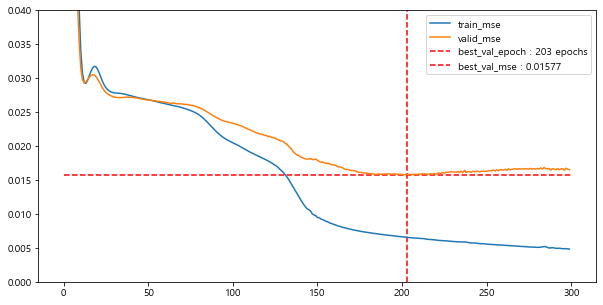

In [5]:
plt.figure(figsize = [10, 5])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = num_epochs,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.04)
plt.show()

In [4]:
best_model = torch.load('models/best_cycles.pkl')

In [5]:
print("evenving cycle results")

train_pred = best_model(train_time, train_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,1]))

valid_pred = best_model(valid_time, valid_notime)
print('valid_error : ',criterion(valid_pred, valid_y[:,:,1]))


evenving cycle results
train_error :  tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward>)
valid_error :  tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward>)


In [6]:
# trend
i = 1
print("evening cycle")
y = torch.cat((train_y[:,:,i], valid_y[:,:,i], test_y[:,:,i]))
zeros = torch.zeros_like(y).to(device)
print('zeros error : ',np.array((criterion(zeros, y)).cpu()))
rand_normal = torch.randn(y.shape).to(device)
print('random normal error : ',np.array((criterion(rand_normal, y)).cpu()))

evening cycle
zeros error :  0.025128432
random normal error :  1.0241485


## 6. 훈련 데이터와 검증 데이터의 성능 비교

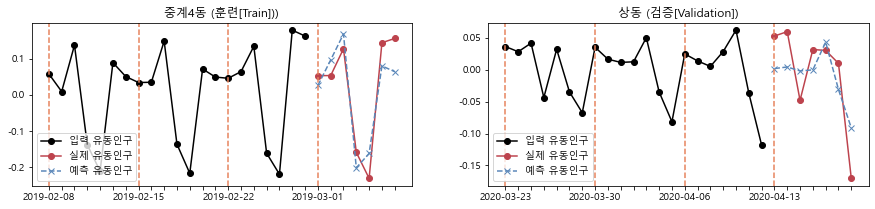

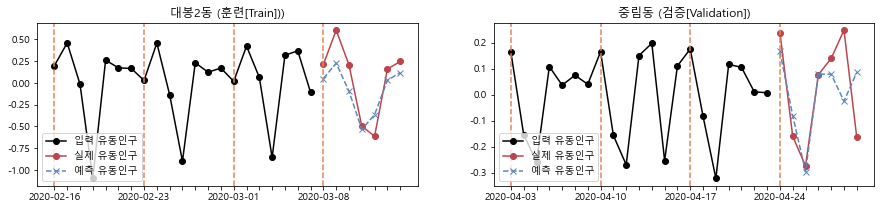

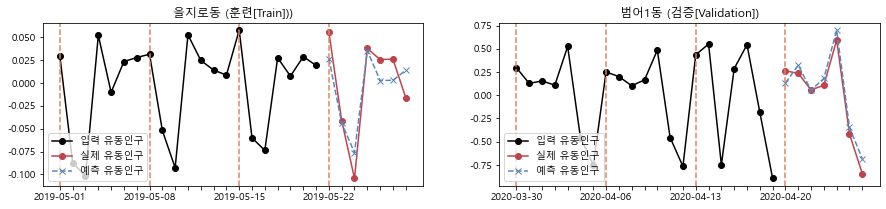

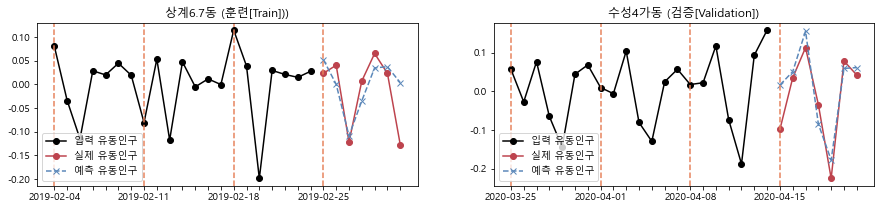

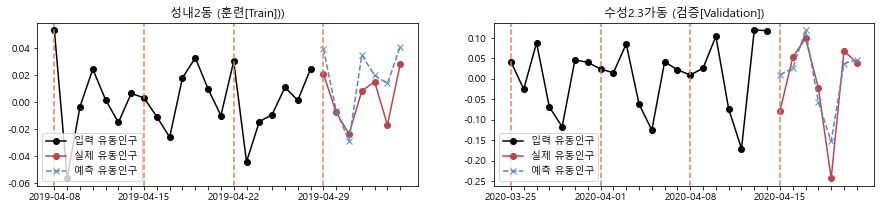

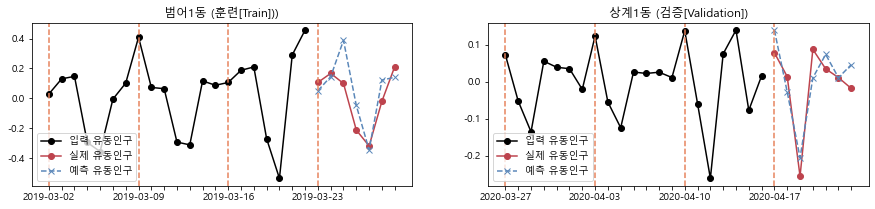

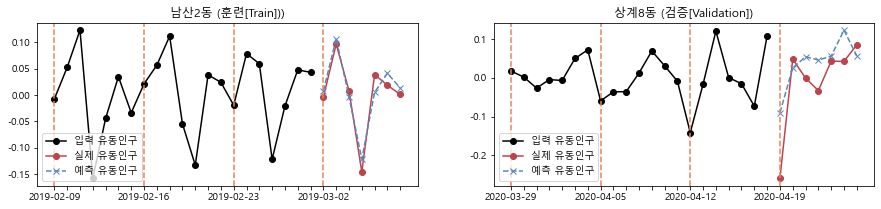

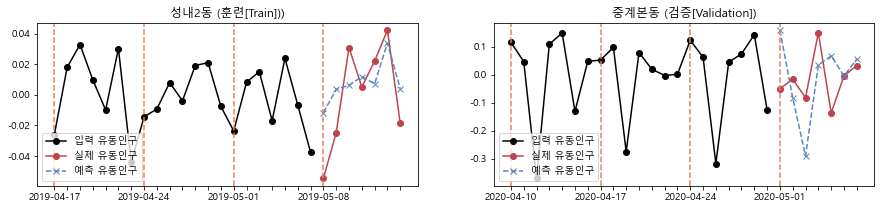

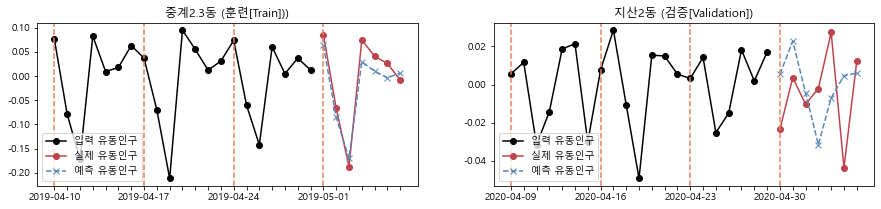

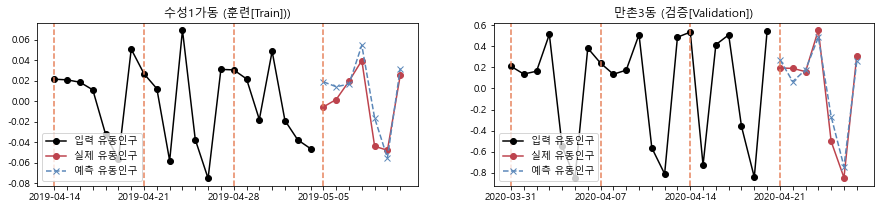

In [21]:
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
# convert result
train_x_np, train_y_np, train_pred_np,\
valid_time_x_np, valid_y_np, valid_pred_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        valid_time[:,:,-1], valid_y[:,:,1], valid_pred])
# plot result
plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_y_np, valid_pred_np)

# save result
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                    valid_time_x_np, valid_y_np, valid_pred_np]
### morning result
path = '../data/train_results/evening_results/'
with open(path + 'e_cycle_results_list.pkl', 'wb') as f:
    pickle.dump(cycle_result_list, f)

## 7. 평가(test set)

In [7]:
test_pred = best_model(test_time, test_notime)
print('test_error : ',criterion(test_pred, test_y[:,:,1]))

test_error :  tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward>)


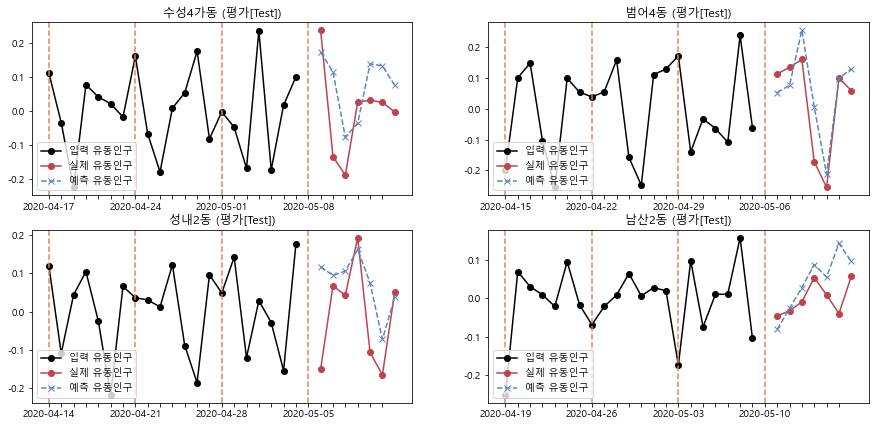

In [22]:
train_pred = best_model(train_time, train_notime)
test_pred = best_model(test_time, test_notime)
# convert result
train_x_np, train_y_np, train_pred_np,\
test_time_x_np, test_y_np, test_pred_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        test_time[:,:,-1], test_y[:,:,1], test_pred])
# plot result
plot_test_predict(test_time_x_np, test_y_np, test_pred_np)

# save result
cycle_test_result = [test_time_x_np, test_y_np, test_pred_np]

path = '../data/train_results/evening_results/'
with open(path + 'e_cycle_results_test.pkl', 'wb') as f:
    pickle.dump(cycle_test_result, f)

## 8. 6월 유동인구 주기(Cycle) 성분 예측

In [23]:
with open('../data/preprocess/june_data/evening_june_time.pkl', 'rb') as f:
    train_time = pickle.load(f)
with open('../data/preprocess/june_data/evening_june_notime.pkl', 'rb') as f:
    train_notime = pickle.load(f)

tc = 1
cycle_size =train_time[:,:,-2].max(axis = 1) - train_time[:,:, -2].min(axis = 1)
train_notime = np.concatenate([train_notime, cycle_size.reshape(-1,1)], axis = 1)

train_time_x, train_notime_x = numpy2tensor([train_time[:,:,3:].astype(np.float64), train_notime.astype(np.float64)])
pred_y = best_model(train_time_x, train_notime_x)
pred_y = np.array(pred_y.cpu().detach())

path = '../data/preprocess/'
with open(path + 'june_evening_cycle_pred.pkl', 'wb') as f:
    pickle.dump(pred_y, f)